Pandas computed Pearson r: 0.2058774513561943
Scipy computed Pearson r: 0.20587745135619348 and p-value: 3.790298947947356e-51


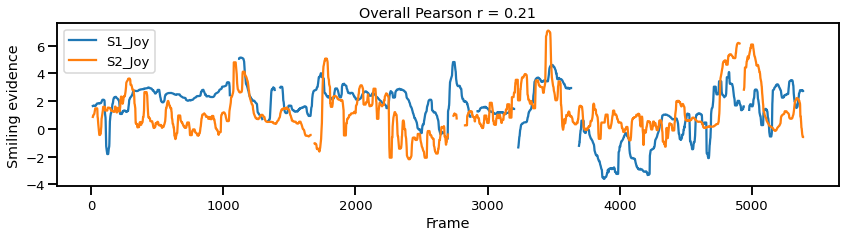

In [1]:
# Windowed time lagged cross correlation
# based on https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_context('talk',font_scale=.8)

df = pd.read_csv('../../../test_data/synchrony_sample.csv')
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

r, p = stats.pearsonr(df.dropna()['S1_Joy'], df.dropna()['S2_Joy'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

f,ax=plt.subplots(figsize=(14,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Frame',ylabel='Smiling evidence',title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

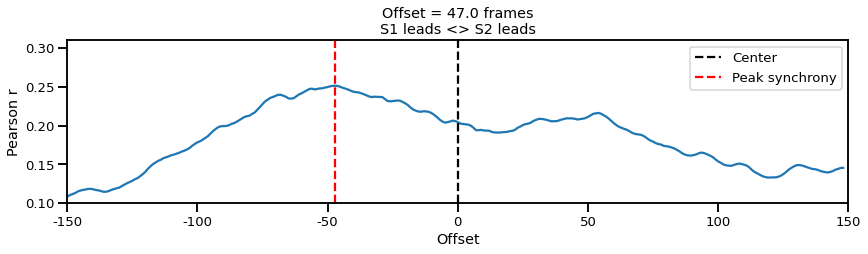

In [4]:
# time-lagged cross correlation
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['S1_Joy']
d2 = df['S2_Joy']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,300], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);
plt.legend()

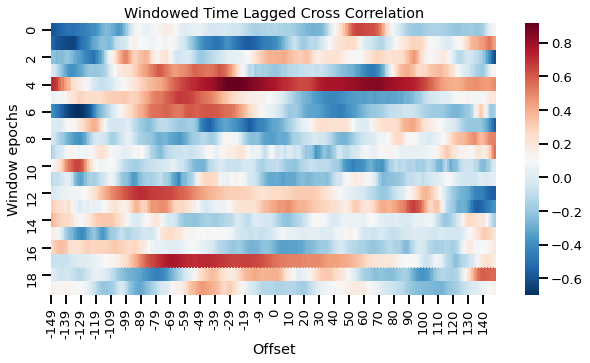

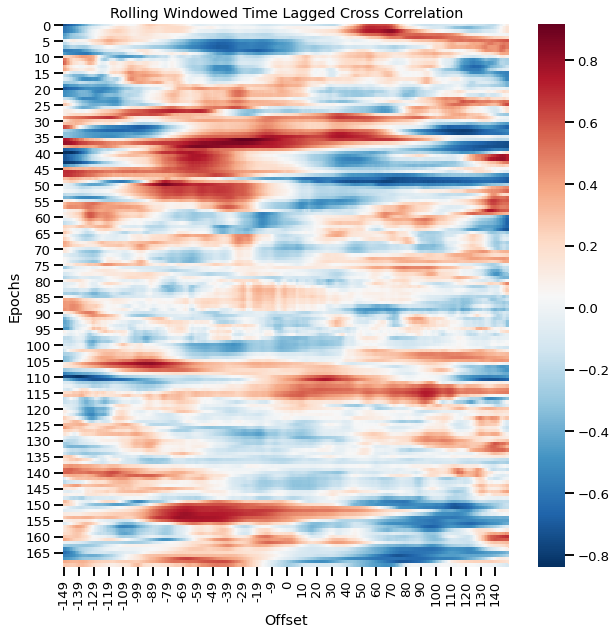

In [5]:
# Windowed time lagged cross correlation
seconds = 5
fps = 30
no_splits = 20
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df['S1_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['S2_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Window epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);

# Rolling window time lagged cross correlation
seconds = 5
fps = 30
window_size = 300 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 5400:
    d1 = df['S1_Joy'].iloc[t_start:t_end]
    d2 = df['S2_Joy'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);